<a href="https://colab.research.google.com/github/Habtamu91/week4/blob/main/Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning for Amharic Named Entity Recognition (NER) from Telegram Data
* To fine-tune an NER model for Amharic using your Telegram data, here's a step-by-step approach:

In [1]:
from google.colab import files
uploaded = files.upload()


Saving telegram_data.xlsx to telegram_data.xlsx


# 1. Data Preparation
* First, we'll need to extract and structure the relevant information from our Excel data:

In [2]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('telegram_data.xlsx')

# Extract messages with Amharic text
amharic_messages = df[df['Message'].notna()]['Message'].tolist()

In [3]:
df.head()

,Channel Title,Channel Username,ID,Message,Date,Media Path
0,Sheger online-store,@Shageronlinestore,5333,NaN,2024-09-20 11:50:03+00:00,photos/@Shageronlinestore_5333.jpg
1,Sheger online-store,@Shageronlinestore,5332,NaN,2024-09-20 11:50:03+00:00,photos/@Shageronlinestore_5332.jpg
2,Sheger online-store,@Shageronlinestore,5331,NaN,2024-09-20 11:50:03+00:00,photos/@Shageronlinestore_5331.jpg
3,Sheger online-store,@Shageronlinestore,5330,NaN,2024-09-20 11:50:02+00:00,photos/@Shageronlinestore_5330.jpg
4,Sheger online-store,@Shageronlinestore,5329,NaN,2024-09-20 11:50:02+00:00,photos/@Shageronlinestore_5329.jpg


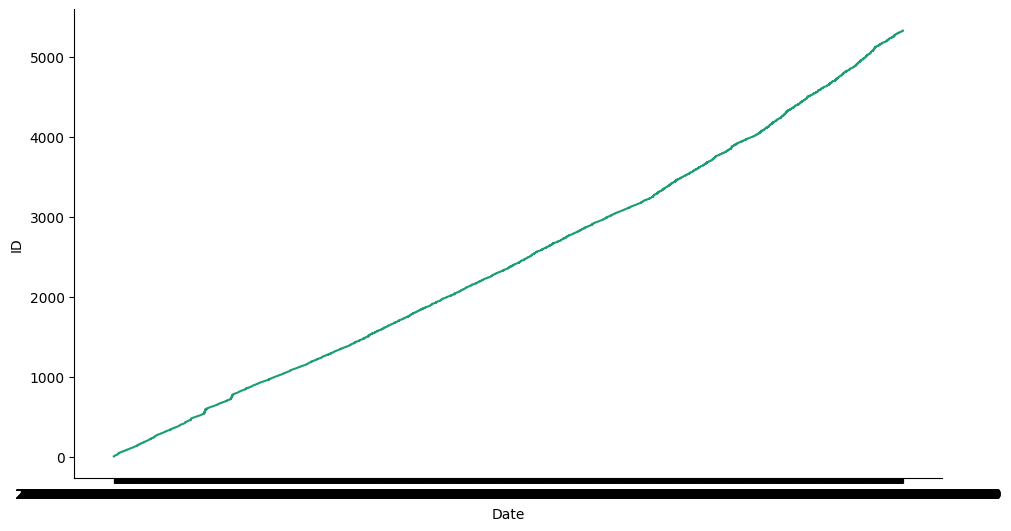

In [ ]:
# @title Date vs ID

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['ID']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('ID')

### Data Summary

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5015 entries, 0 to 5014
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Channel Title     5015 non-null   object
 1   Channel Username  5015 non-null   object
 2   ID                5015 non-null   int64 
 3   Message           3166 non-null   object
 4   Date              5015 non-null   object
 5   Media Path        3794 non-null   object
dtypes: int64(1), object(5)
memory usage: 235.2+ KB


###  Checking for Missing Values

In [5]:
df.isnull().sum()


,0
Channel Title,0
Channel Username,0
ID,0
Message,1849
Date,0
Media Path,1221


In [6]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')



### Droping Missing Values

In [7]:
# Drop rows where both Message and Media Path are missing.
df = df.dropna(subset=['Message'], how='all')
df = df.dropna(subset=['Media Path'], how='all')


In [8]:
df.isnull().sum()

,0
Channel Title,0
Channel Username,0
ID,0
Message,0
Date,0
Media Path,0


# 2. Annotation Guidelines
## Define our entity types based on what appears in our data:

* Products (e.g., "ሴራሚክ የላዛኛ መስሪያ", "የፀጉር ፔስትራ")
* Prices (e.g., "1200 ብር", "500 ብር")
* Locations/Addresses (e.g., "ስሪ ኤም ሲቲ ሞል ሁለተኛ ፎቅ")
* Phone numbers
* Measurements (e.g., "3ሜትር", "45ሳ.ሜ")

# 3. Data Annotation
* We'll need to annotate our data in BIO format.
### For annotation,We can use tools like:
* Doccano (open source)

### Preprocessing Recomendation

In [9]:
import re

def preprocess_amharic_text(text):
    # Normalize Ethiopic numbers if present
    text = text.replace('፩', '1').replace('፪', '2') # etc for all Ethiopic numbers

    # Standardize price formats
    text = re.sub(r'(\d+)\s*ብር', r'\1 ብር', text)

    # Remove excessive whitespace and line breaks
    text = ' '.join(text.split())

    return text

# 4. Model Selection
### For Amharic NER, consider these options:

## Option A: Use AfroXLMRoberta (better for African languages)

In [10]:
model_name = "Davlan/afro-xlmr-base"

# 5. Training Code Example

In [11]:
# STEP 1: Install required libraries
!pip install -q transformers datasets seqeval

# STEP 2: Upload your .conll file
from google.colab import files
uploaded = files.upload()  # Upload 'ner_data.conll'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Saving ner_data.conll to ner_data.conll


In [16]:
from datasets import Dataset
import pandas as pd

# STEP 3: Read the CoNLL file safely
sentences = []
labels = []
tokens = []
tags = []

with open("ner_data.conll", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            if tokens:
                sentences.append(tokens)
                labels.append(tags)
                tokens, tags = [], []
        else:
            try:
                token, tag = line.rsplit(" ", 1)  # Safely split line with space in token
                tokens.append(token)
                tags.append(tag)
            except ValueError:
                print(f"Skipping malformed line: {line}")

# Catch any remaining sentence
if tokens:
    sentences.append(tokens)
    labels.append(tags)

# STEP 4: Define label list and mappings
label_list = sorted(set(tag for tag_list in labels for tag in tag_list))
label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

# STEP 5: Convert to numeric labels and create Dataset
data = {
    "tokens": sentences,
    "ner_tags": [[label_to_id[tag] for tag in tag_list] for tag_list in labels]
}

dataset = Dataset.from_dict(data)

# If you are using same data for training and eval (just for testing):
train_dataset = dataset
eval_dataset = dataset

# Optional: print a sample
print("Sample:", train_dataset[0])
print("Label list:", label_list)


Skipping malformed line: እስከ	O	O
Skipping malformed line: ሙቀት	O	O
Skipping malformed line: መቆቆም	O	O
Skipping malformed line: የሚችል	O	O
Skipping malformed line: ዋጋ-ብር✅	O	O
Skipping malformed line: አድራሻ	O	O
Skipping malformed line: ቁ.	O	O
Skipping malformed line: ስሪ	O	O
Skipping malformed line: ኤም	O	O
Skipping malformed line: ሲቲ	O	O
Skipping malformed line: ሞል	O	O
Skipping malformed line: ሁለተኛ	O	O
Skipping malformed line: ፎቅ	O	O
Skipping malformed line: ቢሮ	O	O
Skipping malformed line: ቁ.	O	O
Skipping malformed line: -(ከ	O	O
Skipping malformed line: ሊፍቱ	O	O
Skipping malformed line: ፊት	O	O
Skipping malformed line: ለ	O	O
Skipping malformed line: ፊት)	O	O
Skipping malformed line: ቁ.	O	O
Skipping malformed line: ለቡ	O	O
Skipping malformed line: መዳህኒዓለም	O	O
Skipping malformed line: ቤተ/ክርስቲያን	O	O
Skipping malformed line: ፊት	O	O
Skipping malformed line: ለፊት	O	O
Skipping malformed line: ኛ	O	O
Skipping malformed line: ፎቅ	O	O
Skipping malformed line: ቢሮ	O	O
Skipping malformed line: ቁጥር.	O	O
Skipping m

In [17]:
# Load Tokenizer and Model
from transformers import AutoTokenizer, AutoModelForTokenClassification
tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-base")
model = AutoModelForTokenClassification.from_pretrained("Davlan/afro-xlmr-base", num_labels=len(label_list))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Step 7: Tokenize and Align Labels
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])
        else:
            labels.append(example["ner_tags"][word_idx])
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

train_dataset = train_dataset.map(tokenize_and_align_labels, batched=False)
eval_dataset = eval_dataset.map(tokenize_and_align_labels, batched=False)


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [32]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    eval_steps=500,               # Evaluate every 500 steps
    save_steps=500,               # Save model every 500 steps
    logging_dir="./logs",
    logging_steps=10
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [22]:
# 1. Define Our Model
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_name = "xlm-roberta-base"  # or "Davlan/bert-base-multilingual-cased-ner-hrl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# 2. Tokenize and Align Labels.
from transformers import DataCollatorForTokenClassification
from datasets import ClassLabel
from transformers import DataCollatorForTokenClassification

label_all_tokens = False  # ✅ Define this BEFORE the function

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])  # Already an integer ID
        else:
            labels.append(example["ner_tags"][word_idx] if label_all_tokens else -100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# ✅ Now this works
tokenized_train = train_dataset.map(tokenize_and_align_labels, batched=False)
tokenized_eval = eval_dataset.map(tokenize_and_align_labels, batched=False)

# Create data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)




Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [36]:

# 3. Initialize Trainer and Train.
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()


/tmp/ipython-input-36-2553798595.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=3, training_loss=0.6347562472025553, metrics={'train_runtime': 91.9809, 'train_samples_per_second': 0.033, 'train_steps_per_second': 0.033, 'total_flos': 13779321156.0, 'train_loss': 0.6347562472025553, 'epoch': 3.0})

In [35]:
# 4. Evaluate the Model
metrics = trainer.evaluate()
print(metrics)


Step,Training Loss,Validation Loss
1,No log,0.666626


{'eval_loss': 0.6666259765625}


In [37]:
# 5. Save the Model
trainer.save_model("my_amharic_ner_model")
tokenizer.save_pretrained("my_amharic_ner_model")


('my_amharic_ner_model/tokenizer_config.json',
 'my_amharic_ner_model/special_tokens_map.json',
 'my_amharic_ner_model/sentencepiece.bpe.model',
 'my_amharic_ner_model/added_tokens.json',
 'my_amharic_ner_model/tokenizer.json')

In [42]:
import numpy as np
from datasets import load_metric

metric = load_metric("seqeval")  # for NER evaluation

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }


In [43]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-43-3391247399.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [44]:
trainer.evaluate()


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ner_data.conll seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TAG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6180331110954285,
 'eval_model_preparation_time': 0.0059,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.5,
 'eval_runtime': 0.3961,
 'eval_samples_per_second': 2.525,
 'eval_steps_per_second': 2.525}